<a href="https://colab.research.google.com/github/nsdevaraj/AIChat/blob/master/TPCH_DuckDB_SF15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate TPCH Parquet files

In [ ]:
sf=15

In [ ]:
!pip install duckdb --pre --upgrade

In [ ]:
%%time
import duckdb
import pathlib


for x in range(0, sf) :
  con=duckdb.connect()
  con.sql('PRAGMA disable_progress_bar;SET preserve_insertion_order=false')
  con.sql(f"CALL dbgen(sf={sf} , children ={sf}, step = {x})") 
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
     pathlib.Path(f'./{tbl}').mkdir(parents=True, exist_ok=True) 
     con.sql(f"COPY (SELECT * FROM {tbl}) TO './{tbl}/{x}.parquet' ")
  con.close()


CPU times: user 14min 34s, sys: 32.9 s, total: 15min 7s
Wall time: 10min 38s


In [ ]:
duckdb.sql(''' select count(*), max (l_orderkey ), min (l_orderkey ), count (distinct l_orderkey ) from './lineitem/*.parquet' ''').show()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

┌──────────────┬─────────────────┬─────────────────┬────────────────────────────┐
│ count_star() │ max(l_orderkey) │ min(l_orderkey) │ count(DISTINCT l_orderkey) │
│    int64     │      int32      │      int32      │           int64            │
├──────────────┼─────────────────┼─────────────────┼────────────────────────────┤
│     89987373 │        90000000 │               1 │                   22500000 │
└──────────────┴─────────────────┴─────────────────┴────────────────────────────┘



# Check the Runtime

In [ ]:
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
mem
runtime = 'TPCH-SF'+str(sf)+' ,DuckDB Running in Google Colab, '+vCPU+' '+str(mem)+'GB'
runtime

'TPCH-SF15 ,DuckDB Running in Google Colab, 2 vCPU 13.0GB'

# Function to Print results

In [ ]:
import time
import pandas as pd
def execute_query(engine, sql_script):
    df = pd.DataFrame(columns=['dur'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try : 
             engine.sql(value).show()
             stop = time.time()
             duration = stop-start
            except  :
               duration =0
            print(duration)
            df = df.append({'dur': duration}, ignore_index=True)
    return df       

# SQL Query

In [ ]:
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;
SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;







SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;


    





SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;


    





SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;


    




SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;


    




SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;


    




SELECT
    --Query08
    o_year,
    SUM(
        CASE
            WHEN nation = 'BRAZIL' THEN volume
            ELSE 0
        END
    ) / SUM(volume) AS mkt_share
FROM
    (
        SELECT
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) AS volume,
            n2.n_name AS nation
        FROM
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        WHERE
            p_partkey = l_partkey
            AND s_suppkey = l_suppkey
            AND l_orderkey = o_orderkey
            AND o_custkey = c_custkey
            AND c_nationkey = n1.n_nationkey
            AND n1.n_regionkey = r_regionkey
            AND r_name = 'AMERICA'
            AND s_nationkey = n2.n_nationkey
            AND o_orderdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
            AND p_type = 'ECONOMY ANODIZED STEEL'
    ) AS all_nations
GROUP BY
    o_year
ORDER BY
    o_year;


    







SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;


    





SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * (0.0001/{sf})
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;


    





SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;


    





SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;


    





SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);


    





SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            supplier_no
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    supplier_no
            ) revenue1
    )
ORDER BY
    s_suppkey;


    





SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;


    





SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );
    





SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;
    




SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );
    





SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;
    





SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;
    





SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;
    
''')

# DuckDB

In [ ]:
%%time
import duckdb 
lineitem=       duckdb.read_parquet('./lineitem/*.parquet')
orders=         duckdb.read_parquet('./orders/*.parquet')
partsupp=       duckdb.read_parquet('./partsupp/*.parquet')
supplier=       duckdb.read_parquet('./supplier/*.parquet')
nation=         duckdb.read_parquet('./nation/*.parquet')
region=         duckdb.read_parquet('./region/*.parquet')
customer=       duckdb.read_parquet('./customer/*.parquet')
part=           duckdb.read_parquet('./part/*.parquet')

CPU times: user 9.61 ms, sys: 943 µs, total: 10.6 ms
Wall time: 11.1 ms


In [ ]:
duckdb.sql('PRAGMA disable_progress_bar')
duck=execute_query(duckdb, sql)

Query1
┌──────────────┬──────────────┬────────────┬───┬────────────────────┬──────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │  sum_qty   │ … │     avg_price      │       avg_disc       │ count_order │
│   varchar    │   varchar    │   int128   │   │       double       │        double        │    int64    │
├──────────────┼──────────────┼────────────┼───┼────────────────────┼──────────────────────┼─────────────┤
│ A            │ F            │  566283055 │ … │  38240.48859308446 │ 0.050007286693869245 │    22206230 │
│ N            │ F            │   14778119 │ … │ 38249.238348227314 │ 0.049949334562842236 │      579093 │
│ N            │ O            │ 1114934274 │ … │  38231.79480757481 │ 0.049996511942548866 │    43726344 │
│ R            │ F            │  566531511 │ … │  38250.75477878017 │  0.05000362045786973 │    22209898 │
├──────────────┴──────────────┴────────────┴───┴────────────────────┴──────────────────────┴─────────────┤
│ 4 rows                      

<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌───────────────┬────────────────────┬────────────────┬───┬─────────────────┬──────────────────────┐
│   s_acctbal   │       s_name       │     n_name     │ … │     s_phone     │      s_comment       │
│ decimal(15,2) │      varchar       │    varchar     │   │     varchar     │       varchar        │
├───────────────┼────────────────────┼────────────────┼───┼─────────────────┼──────────────────────┤
│       9999.65 │ Supplier#000143654 │ FRANCE         │ … │ 16-166-504-5864 │ are quickly along …  │
│       9994.66 │ Supplier#000071807 │ FRANCE         │ … │ 16-407-922-3032 │ otes sleep accordi…  │
│       9993.32 │ Supplier#000119310 │ FRANCE         │ … │ 16-369-729-8742 │  the slyly final i…  │
│       9990.13 │ Supplier#000138240 │ FRANCE         │ … │ 16-206-608-6166 │ fluffily slyly sil…  │
│       9990.03 │ Supplier#000081720 │ UNITED KINGDOM │ … │ 33-166-373-3036 │ blithely even warh…  │
│       9988.67 │ Supplier#000121595 │ ROMANIA        │ … │ 29-614-101-4146 │ ut the slyly 

<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌────────────┬───────────────┬─────────────┬────────────────┐
│ l_orderkey │    revenue    │ o_orderdate │ o_shippriority │
│   int32    │ decimal(38,4) │    date     │     int32      │
├────────────┼───────────────┼─────────────┼────────────────┤
│   67693986 │   469680.8259 │ 1995-03-08  │              0 │
│    9806272 │   456859.4748 │ 1995-03-13  │              0 │
│   52505473 │   454002.0615 │ 1995-03-05  │              0 │
│   17349504 │   447548.8471 │ 1995-03-08  │              0 │
│   31692004 │   440817.3622 │ 1995-03-10  │              0 │
│    9664483 │   437188.5350 │ 1995-03-10  │              0 │
│   46048610 │   433037.0932 │ 1995-03-12  │              0 │
│   88139201 │   432986.1305 │ 1995-02-25  │              0 │
│   28840519 │   431876.7932 │ 1995-03-08  │              0 │
│   17920644 │   425800.7451 │ 1995-02-19  │              0 │
├────────────┴───────────────┴─────────────┴────────────────┤
│ 10 rows                                         4 columns │
└───────

<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌─────────────────┬─────────────┐
│ o_orderpriority │ order_count │
│     varchar     │    int64    │
├─────────────────┼─────────────┤
│ 1-URGENT        │      157870 │
│ 2-HIGH          │      157386 │
│ 3-MEDIUM        │      157827 │
│ 4-NOT SPECIFIED │      157973 │
│ 5-LOW           │      157841 │
└─────────────────┴─────────────┘

12.0886869430542
Query5


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌───────────┬────────────────┐
│  n_name   │    revenue     │
│  varchar  │ decimal(38,4)  │
├───────────┼────────────────┤
│ INDIA     │ 807162704.9945 │
│ INDONESIA │ 794992237.8333 │
│ JAPAN     │ 786252947.6431 │
│ VIETNAM   │ 785991762.3992 │
│ CHINA     │ 780676147.0258 │
└───────────┴────────────────┘

12.967633247375488
Query6


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌─────────────────┐
│     revenue     │
│  decimal(38,4)  │
├─────────────────┤
│ 1845203145.7185 │
└─────────────────┘

7.321207523345947
Query7


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌─────────────┬─────────────┬────────┬────────────────┐
│ supp_nation │ cust_nation │ l_year │    revenue     │
│   varchar   │   varchar   │ int64  │ decimal(38,4)  │
├─────────────┼─────────────┼────────┼────────────────┤
│ FRANCE      │ GERMANY     │   1995 │ 785342137.9631 │
│ FRANCE      │ GERMANY     │   1996 │ 783623863.5966 │
│ GERMANY     │ FRANCE      │   1995 │ 807828736.9816 │
│ GERMANY     │ FRANCE      │   1996 │ 814530624.2013 │
└─────────────┴─────────────┴────────┴────────────────┘

22.62001323699951
Query8


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌────────┬─────────────────────┐
│ o_year │      mkt_share      │
│ int64  │       double        │
├────────┼─────────────────────┤
│   1995 │ 0.03817820516208833 │
│   1996 │ 0.04179790191409752 │
└────────┴─────────────────────┘

15.890754222869873
Query9


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 410610697.2807 │
│ ALGERIA       │   1997 │ 701030233.6608 │
│ ALGERIA       │   1996 │ 700061883.4468 │
│ ALGERIA       │   1995 │ 696039342.6360 │
│ ALGERIA       │   1994 │ 702978814.2224 │
│ ALGERIA       │   1993 │ 710242883.4266 │
│ ALGERIA       │   1992 │ 693243390.7654 │
│ ARGENTINA     │   1998 │ 413146168.4618 │
│ ARGENTINA     │   1997 │ 704635124.4717 │
│ ARGENTINA     │   1996 │ 699867815.4817 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 693900218.0626 │
│ UNITED STATES │   1993 │ 701922187.6054 │
│ UNITED STATES │   1992 │ 697701794.7469 │
│ VIETNAM       │   1998 │ 417817038.6729 │
│ VIETNAM       │   1997 │ 703173113.6995 │
│ VIETNAM       │   1996 │ 70471

<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌───────────┬────────────────────┬───────────────┬───┬──────────────────────┬─────────────────┬──────────────────────┐
│ c_custkey │       c_name       │    revenue    │ … │      c_address       │     c_phone     │      c_comment       │
│   int32   │      varchar       │ decimal(38,4) │   │       varchar        │     varchar     │       varchar        │
├───────────┼────────────────────┼───────────────┼───┼──────────────────────┼─────────────────┼──────────────────────┤
│    983437 │ Customer#000983437 │   953368.4877 │ … │ pEp0lDi7fsC3K3591t…  │ 28-276-586-8161 │ ckages sleep quick…  │
│    249040 │ Customer#000249040 │   883207.2555 │ … │ ETzilF2LdYbxb3B4xS…  │ 32-758-216-8999 │ ully regular packa…  │
│   1808053 │ Customer#001808053 │   800671.2941 │ … │ KTnVRBNSmrAkaljwG …  │ 18-603-652-3092 │ final theodolites.…  │
│    846535 │ Customer#000846535 │   799381.2529 │ … │ MRrJxm6elE           │ 30-449-686-1581 │ alongside of the s…  │
│    388990 │ Customer#000388990 │   798321.1532

<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌────────────┬───────────────┐
│ ps_partkey │     value     │
│   int32    │ decimal(38,2) │
├────────────┼───────────────┤
│    2780439 │   21156021.99 │
│     114426 │   21005183.74 │
│    2287262 │   19892944.38 │
│      76926 │   19419958.08 │
│    1729252 │   19360823.12 │
│    1398331 │   18957155.22 │
│    2145921 │   18952618.33 │
│    1987268 │   18926840.14 │
│     231341 │   18897170.16 │
│     930028 │   18634219.75 │
│        ·   │         ·     │
│        ·   │         ·     │
│        ·   │         ·     │
│     237782 │    8426073.60 │
│     609296 │    8425872.64 │
│    1621413 │    8425811.16 │
│    1722384 │    8425707.87 │
│    1813621 │    8425576.86 │
│    2951798 │    8425309.33 │
│    2151859 │    8425300.74 │
│     576992 │    8425207.70 │
│    2993511 │    8425200.96 │
│     222309 │    8425193.88 │
├────────────┴───────────────┤
│ ? rows           2 columns │
└────────────────────────────┘

1.2543928623199463
Query12


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌────────────┬─────────────────┬────────────────┐
│ l_shipmode │ high_line_count │ low_line_count │
│  varchar   │     int128      │     int128     │
├────────────┼─────────────────┼────────────────┤
│ MAIL       │           92997 │         139799 │
│ SHIP       │           93530 │         139811 │
└────────────┴─────────────────┴────────────────┘

10.827750444412231
Query13


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   750044 │
│      10 │    99091 │
│       9 │    97917 │
│      11 │    93298 │
│       8 │    87199 │
│      12 │    83851 │
│      13 │    74822 │
│      19 │    70200 │
│       7 │    69804 │
│      18 │    69532 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │      344 │
│      36 │      215 │
│      37 │      120 │
│      38 │       61 │
│      39 │       25 │
│      40 │       16 │
│      41 │        8 │
│      44 │        3 │
│      43 │        3 │
│      42 │        2 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

12.26956844329834
Query14


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.618391847193298 │
└────────────────────┘

5.942635774612427
Query15


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌───────────┬────────────────────┬──────────────────────────┬─────────────────┬───────────────┐
│ s_suppkey │       s_name       │        s_address         │     s_phone     │ total_revenue │
│   int32   │      varchar       │         varchar          │     varchar     │ decimal(38,4) │
├───────────┼────────────────────┼──────────────────────────┼─────────────────┼───────────────┤
│     79948 │ Supplier#000079948 │ Rj913pjXOxVibxfbtithPqIp │ 27-147-439-1111 │  1994272.9699 │
└───────────┴────────────────────┴──────────────────────────┴─────────────────┴───────────────┘

12.814265489578247
Query16


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌──────────┬──────────────────────────┬────────┬──────────────┐
│ p_brand  │          p_type          │ p_size │ supplier_cnt │
│ varchar  │         varchar          │ int32  │    int64     │
├──────────┼──────────────────────────┼────────┼──────────────┤
│ Brand#44 │ STANDARD PLATED TIN      │      9 │          152 │
│ Brand#35 │ PROMO BURNISHED TIN      │      9 │          140 │
│ Brand#54 │ STANDARD BRUSHED COPPER  │     19 │          140 │
│ Brand#13 │ MEDIUM BRUSHED COPPER    │      3 │          132 │
│ Brand#14 │ STANDARD POLISHED COPPER │      3 │          132 │
│ Brand#34 │ ECONOMY POLISHED BRASS   │     19 │          132 │
│ Brand#14 │ ECONOMY BRUSHED COPPER   │     19 │          128 │
│ Brand#24 │ MEDIUM ANODIZED TIN      │      3 │          128 │
│ Brand#31 │ ECONOMY BURNISHED TIN    │     45 │          128 │
│ Brand#43 │ LARGE PLATED COPPER      │     19 │          128 │
│    ·     │          ·               │      · │            · │
│    ·     │          ·               │ 

<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌───────────────────┐
│    avg_yearly     │
│      double       │
├───────────────────┤
│ 4878264.028571429 │
└───────────────────┘

20.080892086029053
Query18


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬─────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l_quantity) │
│      varchar       │   int32   │   int32    │    date     │ decimal(15,2) │     int128      │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼─────────────────┤
│ Customer#000223958 │    223958 │   44769410 │ 1996-06-28  │     565258.20 │             311 │
│ Customer#001353907 │   1353907 │   85901154 │ 1995-10-21  │     563055.55 │             318 │
│ Customer#001003429 │   1003429 │   78502660 │ 1993-03-15  │     562588.69 │             309 │
│ Customer#001890685 │   1890685 │   75784770 │ 1994-02-15  │     552668.23 │             305 │
│ Customer#001962563 │   1962563 │   28077922 │ 1996-10-27  │     552156.51 │             319 │
│ Customer#000318676 │    318676 │   23245603 │ 1994-11-22  │     548359.03 │             321 │
│ Customer#001563707 │   1563707 │   206

<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌───────────────┐
│    revenue    │
│ decimal(38,4) │
├───────────────┤
│ 45619625.8240 │
└───────────────┘

13.435887336730957
Query20


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌────────────────────┬─────────────────────────────────────────┐
│       s_name       │                s_address                │
│      varchar       │                 varchar                 │
├────────────────────┼─────────────────────────────────────────┤
│ Supplier#000000013 │ kgTZjbt4CAa4c3SlirlBLqIL41YbCj          │
│ Supplier#000000287 │ UQR8bUA4V2HxVbw9K                       │
│ Supplier#000000358 │ 6XtuJkJj83BcCOV7bwV7wG5nkhazk           │
│ Supplier#000000378 │ mLPJtpu4wOc cSFzBR                      │
│ Supplier#000000402 │ JR8vWoCteJtJg3okRpt0r28KEo              │
│ Supplier#000000475 │ vvW5U1Waa4sfiVaLrmcguWhnrqWoAZzHsQcFQR2 │
│ Supplier#000000530 │ 0BvoewCPg2scOEfuL93FRKqSxHmdhw1         │
│ Supplier#000000555 │ 8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke           │
│ Supplier#000000657 │ EQzYLK9veRU4SmmB2Bpd                    │
│ Supplier#000000729 │ CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI      │
│         ·          │            ·                            │
│         ·          │   

<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000036238 │      22 │
│ Supplier#000081083 │      22 │
│ Supplier#000089270 │      22 │
│ Supplier#000081265 │      21 │
│ Supplier#000087619 │      21 │
│ Supplier#000144742 │      21 │
│ Supplier#000144826 │      21 │
│ Supplier#000149667 │      21 │
│ Supplier#000000920 │      20 │
│ Supplier#000001083 │      20 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000000633 │      17 │
│ Supplier#000004472 │      17 │
│ Supplier#000006241 │      17 │
│ Supplier#000006384 │      17 │
│ Supplier#000009721 │      17 │
│ Supplier#000009758 │      17 │
│ Supplier#000009850 │      17 │
│ Supplier#000010152 │      17 │
│ Supplier#000012512 │      17 │
│ Supplier#000018000 │      17 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

31.947984

<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


┌───────────┬─────────┬───────────────┐
│ cntrycode │ numcust │  totacctbal   │
│  varchar  │  int64  │ decimal(38,2) │
├───────────┼─────────┼───────────────┤
│ 13        │   13663 │  102312304.55 │
│ 17        │   13587 │  101781654.95 │
│ 18        │   13850 │  103998018.90 │
│ 23        │   13599 │  102304102.53 │
│ 29        │   13727 │  102994414.48 │
│ 30        │   13886 │  104189927.29 │
│ 31        │   13603 │  102133083.10 │
└───────────┴─────────┴───────────────┘

3.0838546752929688


<ipython-input-6-f8726e6c5cbf>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'dur': duration}, ignore_index=True)


# Result

In [ ]:
import numpy as np
duck['query'] = duck.index
con1=duckdb.connect()
concat = con1.sql('''select  duck.dur as Parquet from duck''').df()
concat.index = np.arange(1, len(concat)+1)
concat

,Parquet
1,18.811516
2,3.704542
3,11.465076
4,12.088687
5,12.967633
6,7.321208
7,22.620013
8,15.890754
9,31.132667
10,12.569738


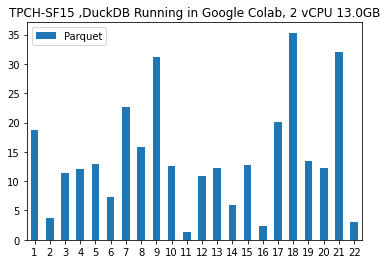

In [ ]:
ax = concat.plot.bar(rot=0,title=runtime)

In [ ]:
summary= con1.sql(' select round(sum(Parquet),2) as Parquet from concat').df()
summary

,Parquet
0,310.18
